# Set Up

In [ ]:
! pip install transformers sentencepiece datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade translatepy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 814.4/814.4 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.0 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset, Dataset, DatasetDict

In [ ]:
import pandas as pd

In [ ]:
from tqdm import tqdm

In [ ]:
from translatepy.translators.google import GoogleTranslate
gtranslate = GoogleTranslate()

In [ ]:
import transformers

# Translation

In [ ]:
dataset = load_dataset('Yukang/LongAlpaca-12k')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

from translate.py

In [ ]:
from translate import dataset_translate

In [ ]:
translated_dataset = dataset_translate(dataset['train'])

  0%|          | 6/12000 [00:19<10:37:56,  3.19s/it]


KeyboardInterrupt: ignored

# Tokenizer count len

Since we specific train for 16k context length so we filter only dataset with lower than 16k token which tokenized with 'openthaigpt/openthaigpt-1.0.0-beta-7b-chat-ckpt-hf'

In [ ]:
dataset = load_dataset('thanaphatt1/LongAlpaca-12k-th')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/11908 [00:00<?, ? examples/s]

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    'openthaigpt/openthaigpt-1.0.0-beta-7b-chat-ckpt-hf',
    model_max_length=32000,
    padding_side="left",
    use_fast=True,
)

tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
    "prompt_no_input_llama2":(
        "[INST] <<SYS>>\n"
        "You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\n"
        "If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n"
        "<</SYS>> \n\n {instruction} [/INST]"
    ),
    "prompt_input_llama2": (
        "[INST] <<SYS>>\n"
        "You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\n"
        "If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n"
        "<</SYS>> \n\n {instruction} \n{input} [/INST]"
    )
}

In [ ]:
prompt_input, prompt_no_input = PROMPT_DICT["prompt_input_llama2"], PROMPT_DICT["prompt_no_input_llama2"]
sources = [
    prompt_input.format_map(example) if example.get("input", "") != "" else prompt_no_input.format_map(example)
    for example in dataset['train']
]

targets = [f"{example['output']}{tokenizer.eos_token}" for example in dataset['train']]
examples = [s + t for s, t in zip(sources, targets)]
# logging.warning("Tokenizing inputs... This may take some time...")
# data_dict = preprocess(sources, targets, tokenizer)

In [ ]:
tokenized_length = []
for i in tqdm(range(len(examples[:]))):
  tokenized = tokenizer(
            examples[i],
            return_tensors="pt",
            padding="longest",
            max_length=tokenizer.model_max_length,
            truncation=False,
        )
  tokenized_length.append(tokenized['input_ids'].shape[1])

100%|██████████| 11908/11908 [24:01<00:00,  8.26it/s] 


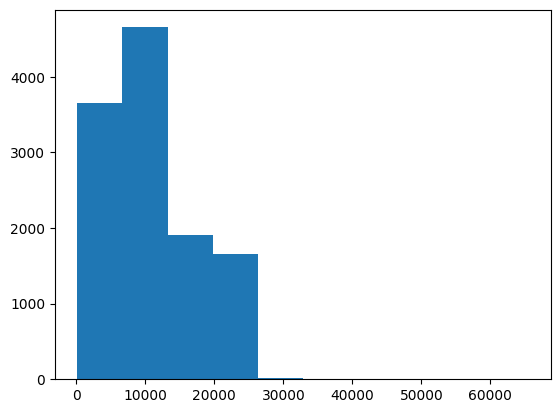

In [ ]:
import matplotlib.pyplot as plt
plt.hist(tokenized_length)
plt.show()

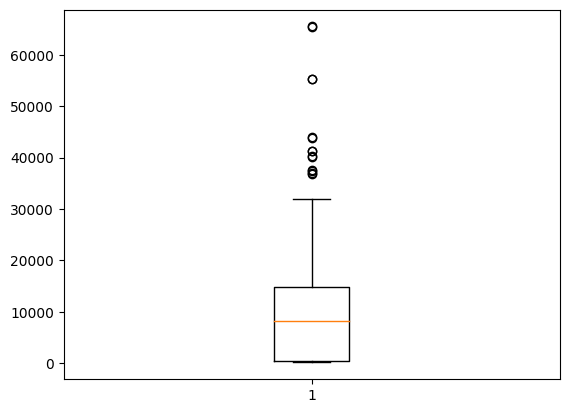

In [ ]:
plt.boxplot(tokenized_length)
plt.show()

In [ ]:
import numpy as np
np.percentile(tokenized_length,81)

15883.35

In [ ]:
over = dataset['train'].select([i for i in range(len(tokenized_length)) if tokenized_length[i] >= 16000])

In [ ]:
below = dataset['train'].select([i for i in range(len(tokenized_length)) if tokenized_length[i] < 16000])

In [ ]:
below

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 9694
})

In [ ]:
below[0]

{'instruction': 'ด้านล่างเป็นกระดาษ จำกระดาษและตอบคำถามของฉันหลังกระดาษ\n กระดาษเริ่มต้นขึ้น\n เชิงนามธรรม\nในการสร้างระบบ Video Question Answering VideoQA) ในกิจกรรมประจำวัน การแสวงหาความสามารถในการช่วยเหลือมนุษย์ในการตอบจากวิดีโอแบบยาวที่มีโมเดล VQA หลายรูปแบบที่มีอยู่ที่หลากหลายและซับซ้อนเพื่อให้บรรลุผลสำเร็จในกิจกรรมต่างๆ เป็นสิ่งจำเป็น ภาพวิดีโอประสิทธิภาพที่น่าหวังหรือคลิปสั้น ในธุรกิจขนาดใหญ่ โดยเฉพาะอย่างยิ่งกับความสำเร็จล่าสุด อย่างไรก็ตาม; เมื่อขยายการฝึกอบรมล่วงหน้าด้านวิธีการเหล่านี้: ความท้าทายเกิดขึ้น: วิดีโอแบบยาว; ods ในกลยุทธ์การสุ่มตัวอย่างใหม่นั้นเป็นวิดีโอที่มีความหนาแน่นสูงโดยใช้การห้ามปรามเชิงสมมุติ ในทางกลับกัน วิธีการต้องอาศัยการต่อสู้ในการสุ่มตัวอย่างแบบกระจัดกระจายในสถานการณ์ที่ต้องใช้การให้เหตุผลด้วยภาพหลายเหตุการณ์และหลายรายละเอียด รุ่นใหม่ชื่อ Multi- ในงานนี้; เราแนะนำ modal Iterative Spatial-temporal Transformer (MIST) เพื่อปรับโมเดลที่ได้รับการฝึกอบรมล่วงหน้าสำหรับ VideoQA แบบยาว: MIST ที่ดีกว่าจะสลายตัวเชิงพื้นที่หนาแน่นแบบดั้งเดิมโดยเฉพาะ การเอาใจใส่ตนเ

# Preprocess

After we exploring the dataset we found that instruction like 'ด้านล่างเป็นกระดาษ' which translated from 'below is paper' is weird so we decided to replace 'กระดาษ' with 'ข้อมูล' to be more generalized

In [ ]:
for datapoint in below:
  print(datapoint)
  break

{'instruction': 'ด้านล่างเป็นกระดาษ จำกระดาษและตอบคำถามของฉันหลังกระดาษ\n กระดาษเริ่มต้นขึ้น\n เชิงนามธรรม\nในการสร้างระบบ Video Question Answering VideoQA) ในกิจกรรมประจำวัน การแสวงหาความสามารถในการช่วยเหลือมนุษย์ในการตอบจากวิดีโอแบบยาวที่มีโมเดล VQA หลายรูปแบบที่มีอยู่ที่หลากหลายและซับซ้อนเพื่อให้บรรลุผลสำเร็จในกิจกรรมต่างๆ เป็นสิ่งจำเป็น ภาพวิดีโอประสิทธิภาพที่น่าหวังหรือคลิปสั้น ในธุรกิจขนาดใหญ่ โดยเฉพาะอย่างยิ่งกับความสำเร็จล่าสุด อย่างไรก็ตาม; เมื่อขยายการฝึกอบรมล่วงหน้าด้านวิธีการเหล่านี้: ความท้าทายเกิดขึ้น: วิดีโอแบบยาว; ods ในกลยุทธ์การสุ่มตัวอย่างใหม่นั้นเป็นวิดีโอที่มีความหนาแน่นสูงโดยใช้การห้ามปรามเชิงสมมุติ ในทางกลับกัน วิธีการต้องอาศัยการต่อสู้ในการสุ่มตัวอย่างแบบกระจัดกระจายในสถานการณ์ที่ต้องใช้การให้เหตุผลด้วยภาพหลายเหตุการณ์และหลายรายละเอียด รุ่นใหม่ชื่อ Multi- ในงานนี้; เราแนะนำ modal Iterative Spatial-temporal Transformer (MIST) เพื่อปรับโมเดลที่ได้รับการฝึกอบรมล่วงหน้าสำหรับ VideoQA แบบยาว: MIST ที่ดีกว่าจะสลายตัวเชิงพื้นที่หนาแน่นแบบดั้งเดิมโดยเฉพาะ การเอาใจใส่ตนเ

In [ ]:
unique_start = set()
unique_end = set()

# Assuming datasets.dataset is an iterable containing your datasets
for datapoint in below:
    # Assuming each datapoint is a list of lines
    instruction = datapoint['instruction'].split('\n')
    start = instruction[0]
    end = instruction[-1]
    # Add the pair to the set to keep track of uniqueness
    unique_start.add(start)
    unique_end.add(end)

In [ ]:
list(unique_start)[0]

'ลบเครื่องหมายวรรคตอนทั้งหมดจากประโยคต่อไปนี้: "เธอพูดว่า \'ฉันจะพบคุณเวลา 16.00 น.\'"'

In [ ]:
list(unique_end)[101]

'สร้างเรื่องสั้นของคุณเองด้วยองค์ประกอบต่อไปนี้: ทะเลทราย, กระบองเพชรและคนแปลกหน้าลึกลับ'

In [ ]:
for instruction in list(unique_start) :
  if "ด้านล่างเป็นกระดาษ" in instruction :
    print(instruction)

ด้านล่างเป็นกระดาษจดจำเนื้อหาและตอบคำถามของฉันหลังจากกระดาษ
ด้านล่างเป็นกระดาษ จำกระดาษและตอบคำถามของฉันหลังกระดาษ
ด้านล่างเป็นกระดาษ จดจำเนื้อหาและตอบคำถามของฉันหลังรายงาน


In [ ]:
def preprocess_dataset(example) :
  # instruction_1 = 'ด้านล่างเป็นกระดาษ จำกระดาษและตอบคำถามของฉันหลังกระดาษ\n กระดาษเริ่มต้นขึ้น'
  # replace_instruction_1 = 'ด้านล่างเป็นเปเปอร์ จดจำข้อมูลในเปเปอร์และตอบคำถามของฉันหลังเปเปอร์นี้จบลง\n เปเปอร์เริ่มต้นขึ้น'
  # if instruction_1 in example['instruction'] :
  example['instruction'] = example['instruction'][:1000].replace('กระดาษ', 'ข้อมูล') +  example['instruction'][1000:]
  example['instruction'] = example['instruction'][:-1000] +  example['instruction'][-1000:].replace('กระดาษ', 'ข้อมูล')
  example['instruction'] = example['instruction'].replace('เชิงนามธรรม', 'Abstract')
  return example

In [ ]:
below = below.map(preprocess_dataset)

Map:   0%|          | 0/9694 [00:00<?, ? examples/s]

In [ ]:
dataset_dict = DatasetDict({'train' : below})

In [ ]:
! huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' creden

In [ ]:
dataset_dict.push_to_hub('thanaphatt1/LongAlpaca-16kcontext-th')

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

# Combine with our wikilongQA

In [ ]:
dataset2 = load_dataset('suncy13/wikiLongQA01')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset2

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 4698
    })
})

In [ ]:
def preprocess_qa(example) :
  # instruction_1 = 'ด้านล่างเป็นกระดาษ จำกระดาษและตอบคำถามของฉันหลังกระดาษ\n กระดาษเริ่มต้นขึ้น'
  # replace_instruction_1 = 'ด้านล่างเป็นเปเปอร์ จดจำข้อมูลในเปเปอร์และตอบคำถามของฉันหลังเปเปอร์นี้จบลง\n เปเปอร์เริ่มต้นขึ้น'
  # if instruction_1 in example['instruction'] :
  start = 'ด้านล่างเป็นข้อมูล จดจำเนื้อหาและตอบคำถามของฉันหลังจากข้อมูลจบลง\n'
  end = '\nข้อมูลสิ้นสุดแล้ว\nคำถาม:'
  example['instruction'] = start + example['input'] + end + example['instruction']
  example['input'] = None
  example['output'] = 'คำตอบ: ' + example['output']
  return example

In [ ]:
dataset2_prep = dataset2.map(preprocess_qa)

Map:   0%|          | 0/4698 [00:00<?, ? examples/s]

In [ ]:
dataset_dict['train']

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 9694
})

In [ ]:
dataset2_prep['train']

Dataset({
    features: ['input', 'output', 'instruction'],
    num_rows: 4698
})

In [ ]:
from datasets import concatenate_datasets

In [ ]:
concat = concatenate_datasets([dataset_dict['train'],dataset2_prep['train']])

In [ ]:
dataset_dict_2 = DatasetDict({'train':concat})

In [ ]:
dataset_dict_2

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 14392
    })
})

In [ ]:
dataset_dict_2.push_to_hub('thanaphatt1/LongAlpaca-16kcontext-th-and-WikiQA')

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

# Combine with original LongAlpaca12k dataset

In [ ]:
dataset_en = load_dataset('Yukang/LongAlpaca-12k')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset_th = load_dataset('thanaphatt1/LongAlpaca-16kcontext-th-and-WikiQA')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/14392 [00:00<?, ? examples/s]

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    'openthaigpt/openthaigpt-1.0.0-beta-7b-chat-ckpt-hf',
    model_max_length=32000,
    padding_side="left",
    use_fast=True,
)

tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
    "prompt_no_input_llama2":(
        "[INST] <<SYS>>\n"
        "You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\n"
        "If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n"
        "<</SYS>> \n\n {instruction} [/INST]"
    ),
    "prompt_input_llama2": (
        "[INST] <<SYS>>\n"
        "You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\n"
        "If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n"
        "<</SYS>> \n\n {instruction} \n{input} [/INST]"
    )
}

In [ ]:
prompt_input, prompt_no_input = PROMPT_DICT["prompt_input_llama2"], PROMPT_DICT["prompt_no_input_llama2"]
sources = [
    prompt_input.format_map(example) if example.get("input", "") != "" else prompt_no_input.format_map(example)
    for example in dataset_en['train']
]

targets = [f"{example['output']}{tokenizer.eos_token}" for example in dataset_en['train']]
examples = [s + t for s, t in zip(sources, targets)]
# logging.warning("Tokenizing inputs... This may take some time...")
# data_dict = preprocess(sources, targets, tokenizer)

In [ ]:
examples[0]

'[INST] <<SYS>>\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don\'t know the answer to a question, please don\'t share false information.\n<</SYS>> \n\n Below is a paper. Memorize the paper and answer my question after the paper.\n The paper begins. \n Abstract\nTo build Video Question Answering VideoQA) systems in daily activities,  seeking capable of assisting humans answers from long-form videos with diverse and complex Existing multi-modal VQA models achieve events is a must. promising performance video images or  short clips; on of large-scale   multi- especially with the recent success However; 

In [ ]:
tokenized_length = []
for i in tqdm(range(len(examples[:]))):
  tokenized = tokenizer(
            examples[i],
            return_tensors="pt",
            padding="longest",
            max_length=tokenizer.model_max_length,
            truncation=False,
        )
  tokenized_length.append(tokenized['input_ids'].shape[1])

100%|██████████| 12000/12000 [29:47<00:00,  6.71it/s] 


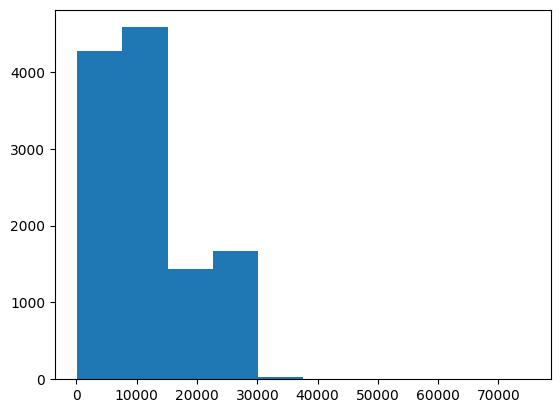

In [ ]:
import matplotlib.pyplot as plt
plt.hist(tokenized_length)
plt.show()

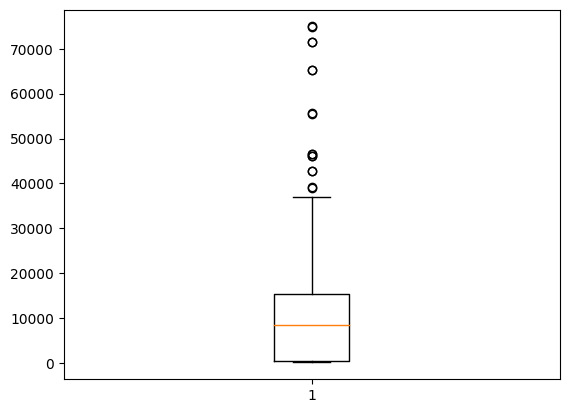

In [ ]:
plt.boxplot(tokenized_length)
plt.show()

In [ ]:
over = dataset_en['train'].select([i for i in range(len(tokenized_length)) if tokenized_length[i] >= 16000])

In [ ]:
below = dataset_en['train'].select([i for i in range(len(tokenized_length)) if tokenized_length[i] < 16000])

In [ ]:
below

Dataset({
    features: ['input', 'file', 'output', 'instruction'],
    num_rows: 9409
})

In [ ]:
from datasets import concatenate_datasets

In [ ]:
concat = concatenate_datasets([dataset_th['train'], below])

In [ ]:
concat

Dataset({
    features: ['instruction', 'input', 'output', 'file'],
    num_rows: 23801
})

In [ ]:
dataset_concat = DatasetDict({'train':concat})

In [ ]:
! huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' creden

In [ ]:
dataset_concat.push_to_hub('thanaphatt1/LongAlpaca-16kcontext-enth-and-WikiQA')

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/408 [00:00<?, ?B/s]

In [ ]:
dataset_concat['train'][0].keys()

dict_keys(['instruction', 'input', 'output', 'file'])

In [ ]:
from translate import translate

In [ ]:
translate(dataset['train'].select([i for i in range(5)]),20000)

TypeError: ignored